In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

#For plotting binned velocity profile
from scipy.stats import binned_statistic as bstats

In [104]:
# Import and apply style file for plots
plt.style.use("mpl.style")

#### System parameters

In [105]:
#LAMMPS script is in LJ units, so make sure these match

#System size
L = 10 #Size of the system
sf = 0.5 #Unit cell size, relative to L
nb = 1 # # of particles per unit cell
n = nb/(sf**2) # # of particles per area L^2
N = n * L**2

#Fluid properties
eta = 0.01
rho = 1
tau = (rho*(L**2))/(eta*(2*np.pi)**2)
m = rho/n

#Spatial velocity profile
# Of the form u_y = a*sin(bx)
a = 0.1
b = 2*np.pi/L

params = [L,tau]

#### Functional Expression for Velocity

In [106]:
def vel_x_t(x,t,params):
    u_x = 0.1*np.sin((2*np.pi*x)/params[0])
    u_t = np.exp(-t/params[1])
    return u_x*u_t

#### Load netCDF datasets

In [107]:
from netCDF4 import Dataset

In [117]:
#Open dataset in read only "r" mode
ds_5 = Dataset('/Users/ericpalermo/dev/test/dump_p5.nc','r')
ds_1 = Dataset('/Users/ericpalermo/dev/test/dump_p1.nc','r')
ds_05 = Dataset('/Users/ericpalermo/dev/test/dump_p05.nc','r')
ds_005 = Dataset('/Users/ericpalermo/dev/test/dump_p005.nc','r')

ds_rk_1 = Dataset('/Users/ericpalermo/dev/test/dump.nc','r')

#Store the datasets and their labels in an array
dump_array = [[ds_5, "0.5",'-'],[ds_1,"0.1",'-'],[ds_05, "0.05",'-'],[ds_005, "0.005",'-'],[ds_rk_1,"0.1 - RK",'o']]

### Spatial Velocity Profile

Text(0, 0.5, 'Velocity')

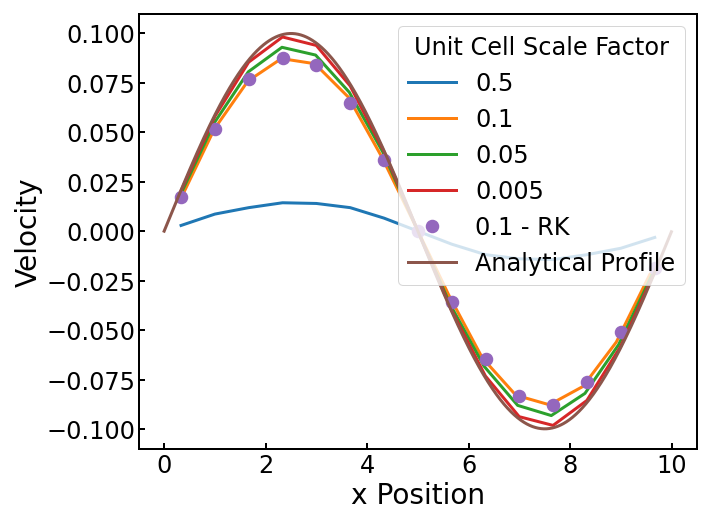

In [119]:
nf = 50 #Timestep at which velocity profile is sampled

fig = plt.figure() #Create figure
ax = fig.add_subplot(111) #Add subplot to figure

for i in dump_array:
    
    #Obtain x pos and y vel from dump file
    xd = i[0]['coordinates'][nf,:,0] #At timestep nf, for all particles, x position
    vyd = i[0]['velocities'][nf,:,1] ##At timestep nf, for all particles, y velocity
    
    #Divide the velocity profile into 8 bins
    stat,xe,_ = bstats(xd,vyd,statistic='mean',bins=15)
    xe = (xe[:-1] + xe[1:])/2
    
    #Plot the binned velocities
    ax.plot((xe), (stat),i[2], label=i[1])
    
#Overlay analytical solution plot
ref_x = np.arange(0,10,0.005)
ref_v = vel_x_t(ref_x,nf/200,params)
ax.plot(ref_x,ref_v,label="Analytical Profile")

#Legend and labels
ax.legend(title = "Unit Cell Scale Factor")
ax.set_xlabel("x Position")
ax.set_ylabel("Velocity")

Note: nf is in increments of 200 timesteps. LAMMPS runs a simulation of 50,000 timesteps and output the data to the dump file every 200 timesteps. Every timestep in the dumpfile is 200 actual timesteps

### Kinetic Energy Profile

Note the structure of the velocities array:
    - One array for each time step
    - Within each timestep array, one array for each atom
    - Within each atom, 3 spatial coordinates
    
netCDF uses masked arrays to hide dimensions not in use. The x and y dimensions will have a "False" value in the mask array (not maksed) and the z dimension will have a "True" value in the mask array (masked)

#### LAMMPS Simulation

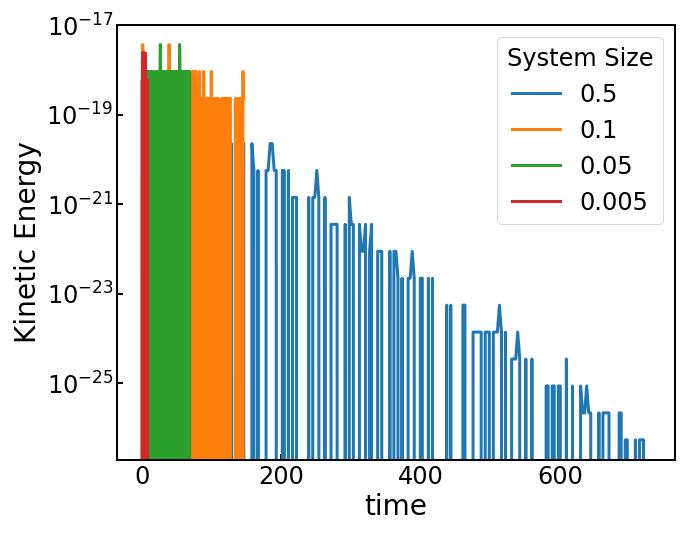

In [110]:
#Create figure
fig = plt.figure()

#Add subplot to figure
ax = fig.add_subplot(111)

#Plot Ek vs t from several datasets
for i in dump_array:
    
    td = i[0]["time"][:] #Timesteps
    vd = i[0]["velocities"][:,:,1]
    Ed = 0.5*m*(np.mean(vd,axis=1))**2 #Kinetic energy
    
    ax.semilogy(td, Ed, label=i[1]) #semilog plot
    
#Legend and labels
    ax.legend(title = "System Size")
    ax.set_xlabel("time")
    ax.set_ylabel("Kinetic Energy")
    

#### Analytical Solution

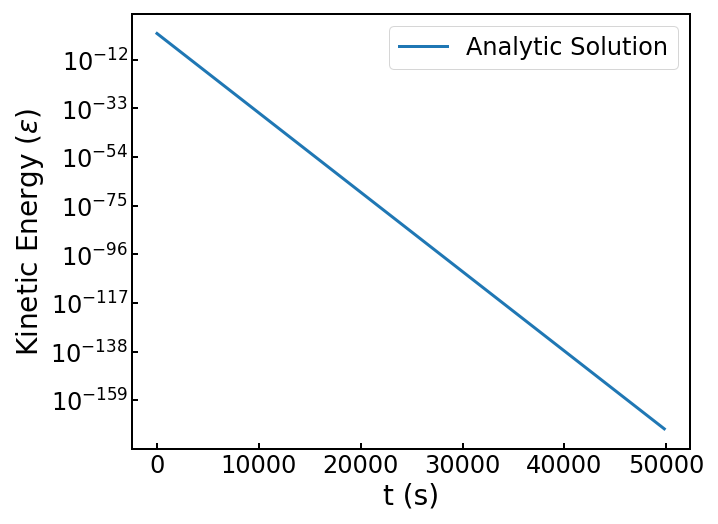

In [111]:

#Array of timesteps
t = np.arange(0,50000, 200)

#Array of x values
x = np.arange(0,L,0.005)

u_x = 0.1*np.sin((2*np.pi*x)/L)
u_t = np.exp(-t/tau)


#Avg velocity square of each particle
u_avg = ((a**2)/L)*((L/2)-(np.sin(2*b*L)/(4*b)))*np.exp(-2*t/tau)

#Avg kinetic energy per particle
E = 0.5*m*u_avg

#Total kinetic energy
E_tot = E * n * L**2


#Create figure
fig = plt.figure()

#Add subplot to figure
ax = fig.add_subplot(111)

#Set data
x = t
y1 = E_tot

#Plot data
ax.semilogy(x, y1, label="Analytic Solution")

#Axis labels
ax.set_xlabel("t (s)")
ax.set_ylabel("Kinetic Energy ($ \epsilon $)")

ax.legend()